# Sentiment Analysis and Engagement Prediction

- In today's interconnected world, global news travels faster than ever, engaging audiences across platforms. This project leverages a dataset featuring **social media interactions** and **news article content** from renowned news outlets, including **Al Jazeera**, **Reuters**, **BBC**, and **CNN**. These outlets provide a rich source of text data and metrics for analyzing social media trends and engagement.

- First, we will apply advanced **Natural Language Processing (NLP)** techniques to perform **sentiment analysis** on the text of news articles. Through detailed visualizations, we aim to uncover patterns in sentiment and its relationship with engagement metrics. 

- Next, we focus on predicting **total engagement**—a combination of **likes**, **comments**, and **shares**—using a robust machine learning model. By exploring and interpreting this dataset, we aim to provide actionable insights into what drives social media interactions with global news.

- The dataset for this project is sourced from [Kaggle: Global News Engagement on Social Media](https://www.kaggle.com/datasets/kanchana1990/global-news-engagement-on-social-media/data).

<div style="text-align: center;">
    <img src="https://library.ceu.edu/wp-content/uploads/news-2444778_960_720.jpg" alt="Image">
</div>

# Importing the necessary packages

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import nltk
import re
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing and preparing the data

In [85]:
#reading files and assigning 'source' column for each
al_j = pd.read_csv('/kaggle/input/global-news-engagement-on-social-media/al_jazeera.csv').assign(source='Al Jazeera')
bbc = pd.read_csv('/kaggle/input/global-news-engagement-on-social-media/bbc.csv').assign(source='BBC')
cnn = pd.read_csv('/kaggle/input/global-news-engagement-on-social-media/cnn.csv').assign(source='CNN')
reuters = pd.read_csv('/kaggle/input/global-news-engagement-on-social-media/reuters.csv').assign(source='Reuters')

#merging data 
df = pd.concat([al_j, bbc, cnn, reuters], ignore_index=True)

# EDA - Exploratory Data Analysis 

In [8]:
df.head()

,text,likes,comments,shares,source
0,“Numbers dropped by around half after the eart...,303,15,5,Al Jazeera
1,This exclusive footage obtained by Al Jazeera ...,809,174,81,Al Jazeera
2,The disappearance of 6-year-old Joshlin Smith ...,236,75,33,Al Jazeera
3,Millions are still suffering the pandemic’s li...,87,11,11,Al Jazeera
4,Multan Sultans face Peshawar Zalmi in the Paki...,522,71,5,Al Jazeera


In [9]:
df.shape

(3753, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3734 non-null   object
 1   likes     3753 non-null   int64 
 2   comments  3753 non-null   int64 
 3   shares    3753 non-null   int64 
 4   source    3753 non-null   object
dtypes: int64(3), object(2)
memory usage: 146.7+ KB


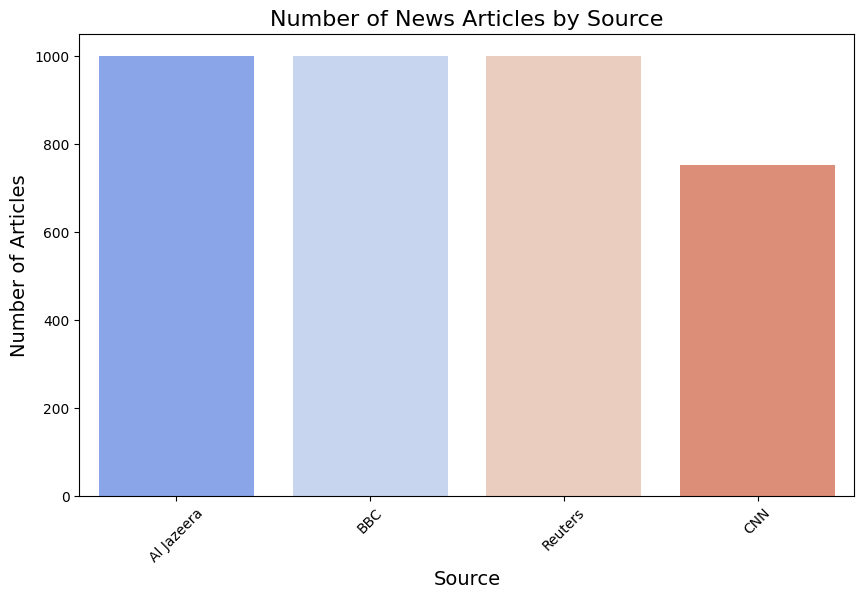

In [31]:
#number of news articles by source in df
source_distribution = df['source'].value_counts().reset_index()
source_distribution.columns = ['source', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='source', y='Count', data=source_distribution, palette='coolwarm')
plt.title('Number of News Articles by Source', fontsize=16)
plt.xlabel('Source', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.show()

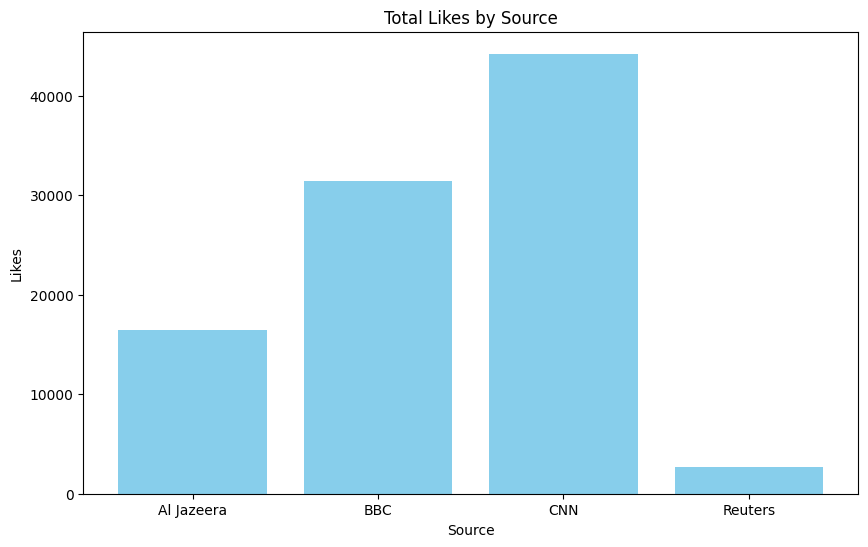

In [14]:
#total likes by source
plt.figure(figsize=(10, 6))
plt.bar(df['source'], df['likes'], color='skyblue')
plt.title('Total Likes by Source')
plt.xlabel('Source')
plt.ylabel('Likes')
plt.show()

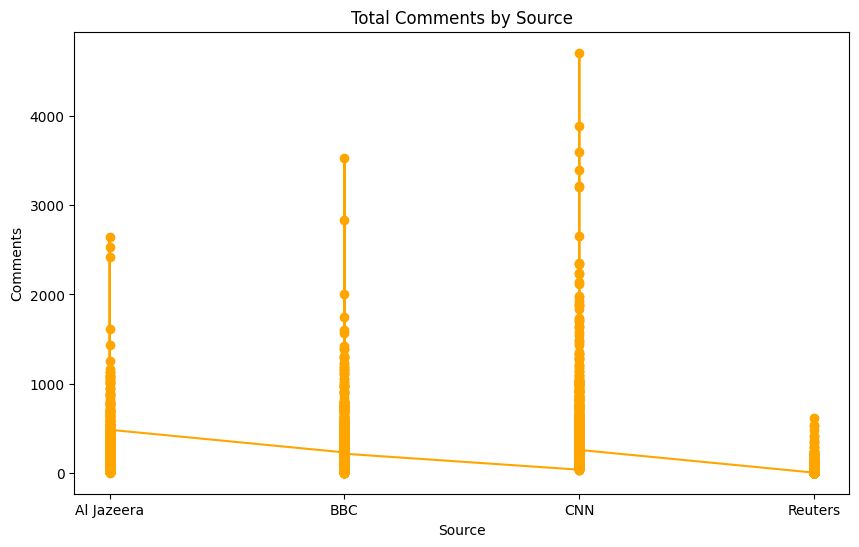

In [15]:
#total comments by source
plt.figure(figsize=(10, 6))
plt.plot(df['source'], df['comments'], marker='o', color='orange')
plt.title('Total Comments by Source')
plt.xlabel('Source')
plt.ylabel('Comments')
plt.show()

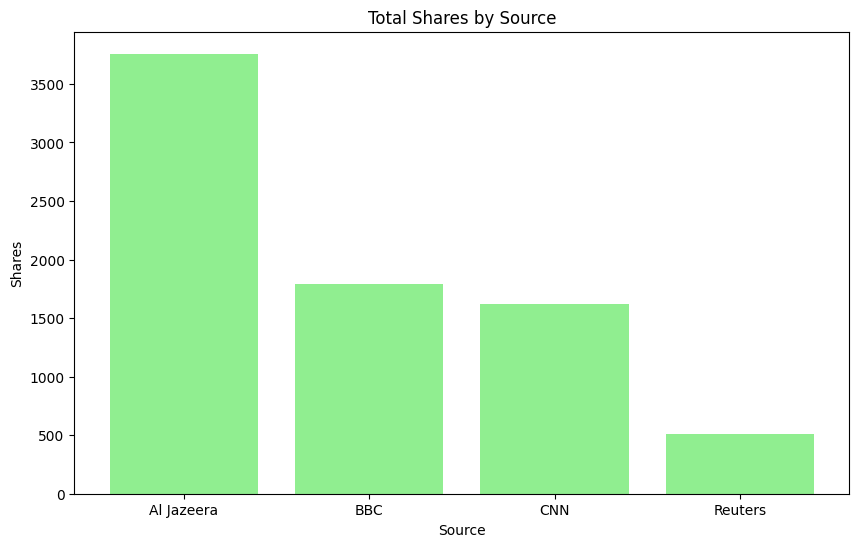

In [16]:
#total shares by source
plt.figure(figsize=(10, 6))
plt.bar(df['source'], df['shares'], color='lightgreen')
plt.title('Total Shares by Source')
plt.xlabel('Source')
plt.ylabel('Shares')
plt.show()

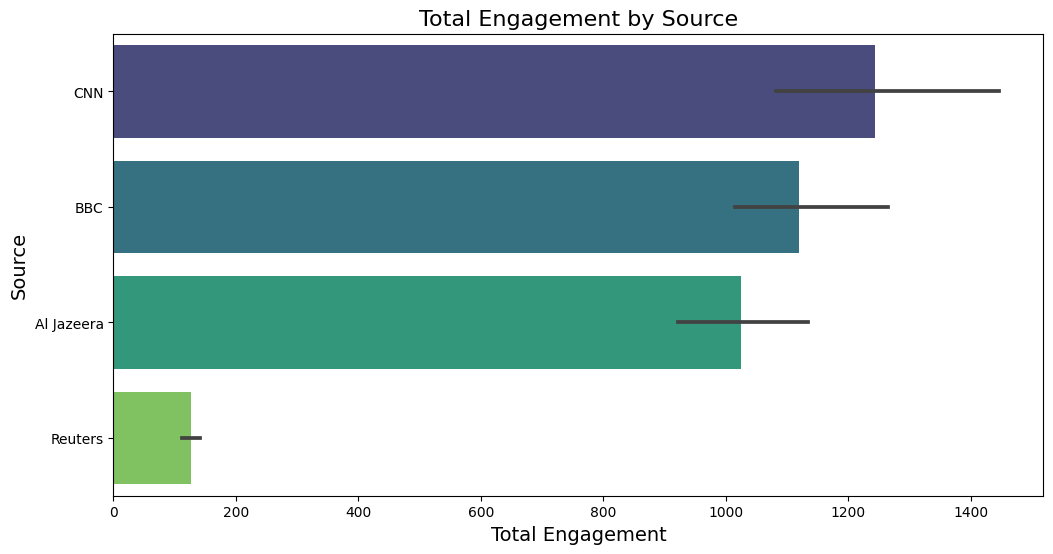

In [86]:
#adding new feature of total engagement and visualization 
df['total engagement'] = df['likes'] + df['comments'] + df['shares']

df_sorted = df.sort_values(by='total engagement', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='total engagement', y='source', data=df_sorted, palette='viridis')
plt.title('Total Engagement by Source', fontsize=16)
plt.xlabel('Total Engagement', fontsize=14)
plt.ylabel('Source', fontsize=14)
plt.show()

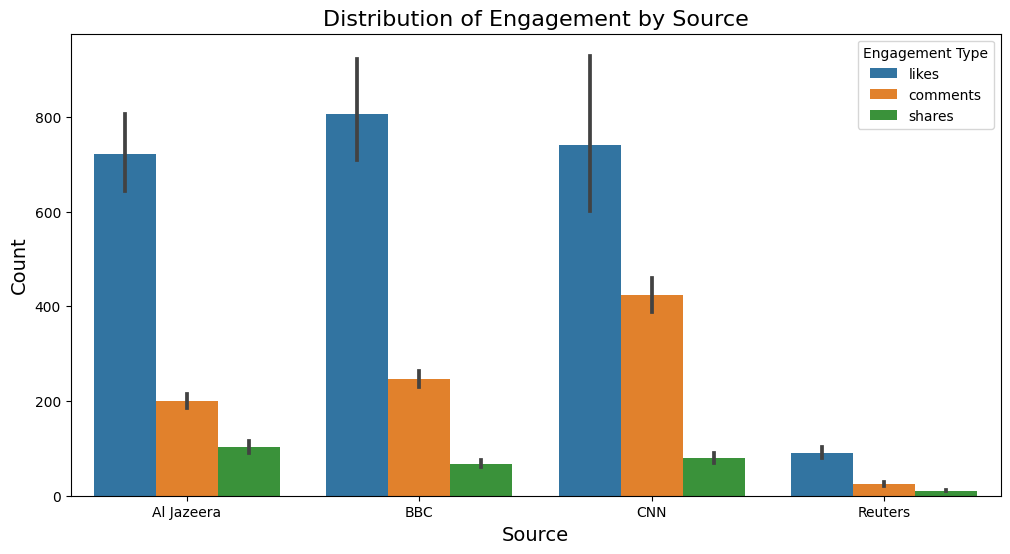

In [29]:
#distribution of engagement by source
df_melted = df.melt(id_vars='source', value_vars=['likes', 'comments', 'shares'], 
                    var_name='Engagement Type', value_name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(x='source', y='Count', hue='Engagement Type', data=df_melted, palette='tab10')
plt.title('Distribution of Engagement by Source', fontsize=16)
plt.xlabel('Source', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Engagement Type')
plt.show()

# Sentiment Analysis

In [87]:
#cleaning the text
df['text'] = df['text'].fillna('').str.lower().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\d+', '', regex=True)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])
    
df['text'] = df['text'].apply(remove_stopwords)

In [88]:
def textblob_analysis(text): 
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = 'Positive' if polarity > 0.1 else 'Negative' if polarity < -0.1 else 'Neutral'
    return polarity, subjectivity, sentiment

#applying the sentiment analysis
df[['Polarity', 'Subjectivity', 'Sentiment']] = df['text'].apply(textblob_analysis).apply(pd.Series)

In [48]:
df.sample(6)

,text,likes,comments,shares,source,total engagement,Polarity,Subjectivity,Sentiment
0,numbers dropped around half earthquake inevita...,303,15,5,Al Jazeera,323,-0.083333,0.583333,Neutral
1,exclusive footage obtained al jazeera shows ex...,809,174,81,Al Jazeera,1064,0.000000,0.000000,Neutral
2,disappearance yearold joshlin smith made natio...,236,75,33,Al Jazeera,344,0.000000,0.000000,Neutral
3,millions still suffering pandemics lingering e...,87,11,11,Al Jazeera,109,-0.112500,0.266667,Negative
4,multan sultans face peshawar zalmi pakistan su...,522,71,5,Al Jazeera,598,0.234848,0.583333,Positive


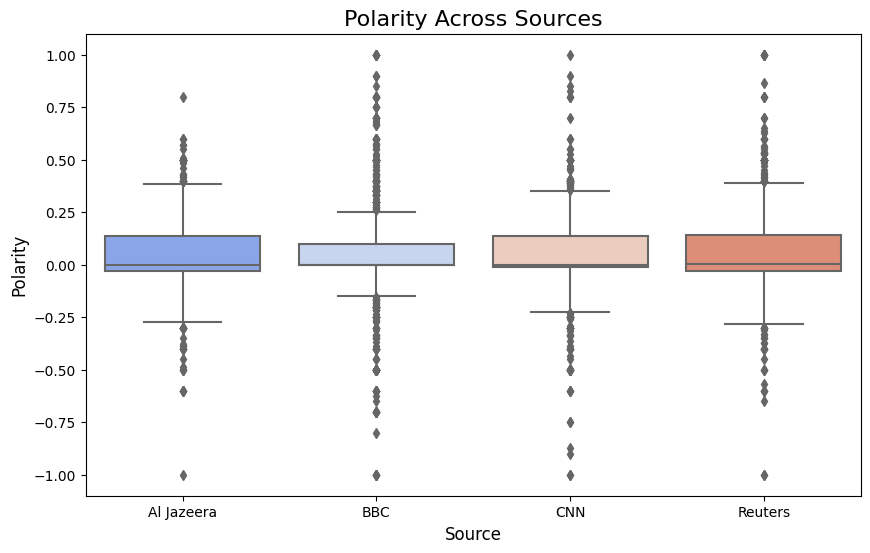

In [65]:
#polarity across sources
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='source', y='Polarity', palette='coolwarm')
plt.title('Polarity Across Sources', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Polarity', fontsize=12)
plt.show()

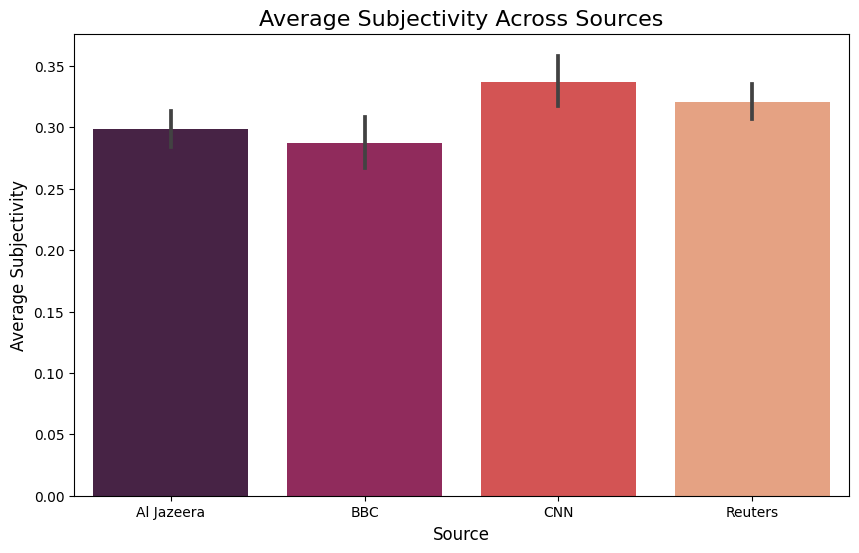

In [64]:
#average subjectivity across sources
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='source', y='Subjectivity', palette='rocket')
plt.title('Average Subjectivity Across Sources', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Average Subjectivity', fontsize=12)
plt.show()

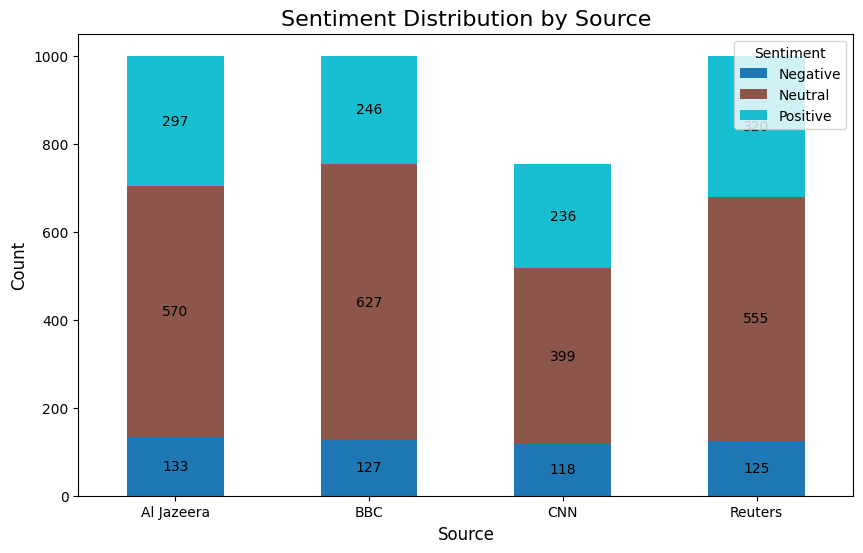

In [62]:
#sentiment distribution by source
sentiment_counts = df.groupby(['source', 'Sentiment']).size().unstack()
ax = sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title('Sentiment Distribution by Source', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Sentiment')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color='black')
plt.show()

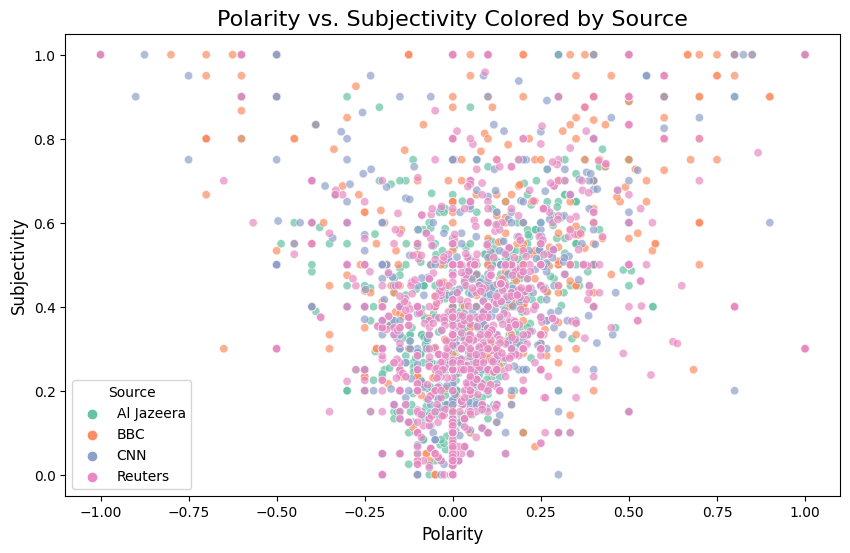

In [55]:
#polarity vs. subjectivity heatmap
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Polarity', y='Subjectivity', hue='source', palette='Set2', alpha=0.7)
plt.title('Polarity vs. Subjectivity Colored by Source', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Subjectivity', fontsize=12)
plt.legend(title='Source')
plt.show()

# Modelling

In [89]:
#preparing the data
x = df.drop(['text','total engagement'],axis=1)
y = df['total engagement']

x = pd.get_dummies(x, drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [90]:
#defining the models
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {"Model": [], "R2 Score": [], "RMSE": []}

#training and evaluating each model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results["Model"].append(name)
    results["R2 Score"].append(r2)
    results["RMSE"].append(rmse)

#creating results table
results_df = pd.DataFrame(results)
results_df

                       Model  R2 Score        RMSE
0  K-Nearest Neighbors (KNN)  0.831170  923.255123
1              Decision Tree  0.936442  566.478801
2              Random Forest  0.883106  768.235727
3          Gradient Boosting  0.928803  599.555646
4                    XGBoost  0.924091  619.077527


In [98]:
#continuing with the best scored algorithm 'Decision Tree Regressor'
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(x_train, y_train)
y_pred = decision_tree_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

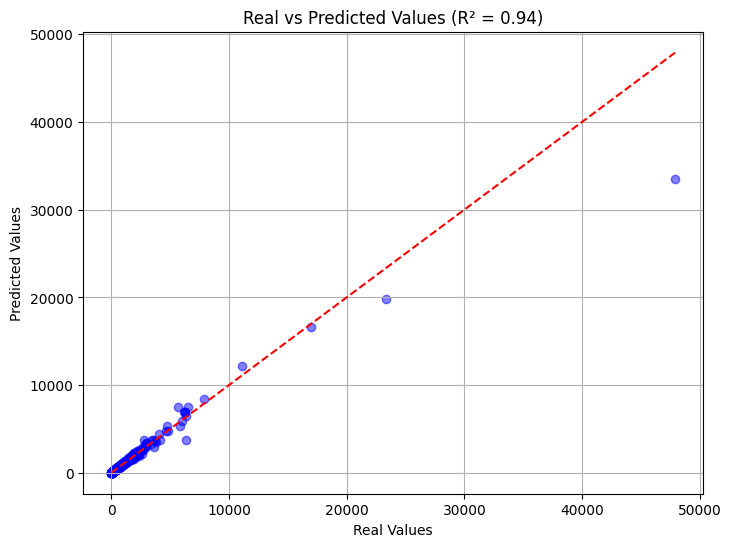

In [105]:
#real vs predicted values graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Real vs Predicted Values (R² = {r2:.2f})')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

In [106]:
rmse

566.4788007428685

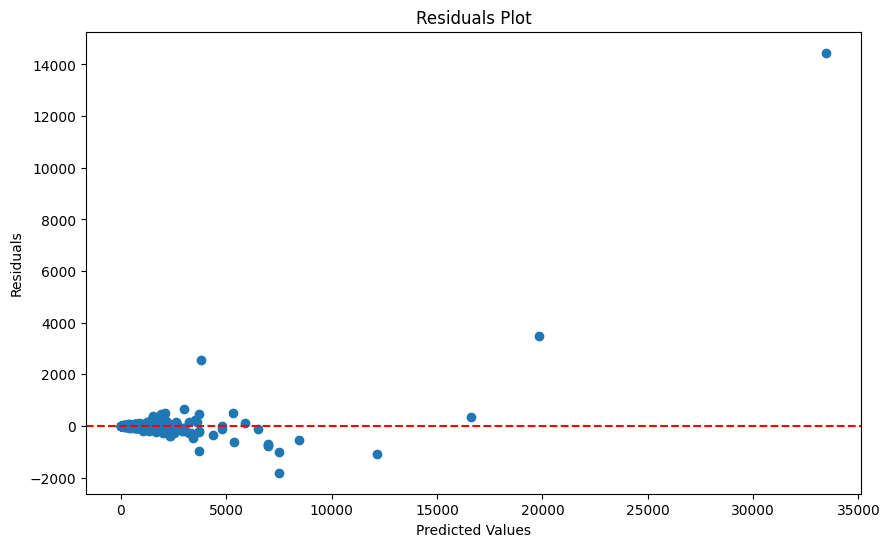

In [108]:
#residuals vs. predicted values
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

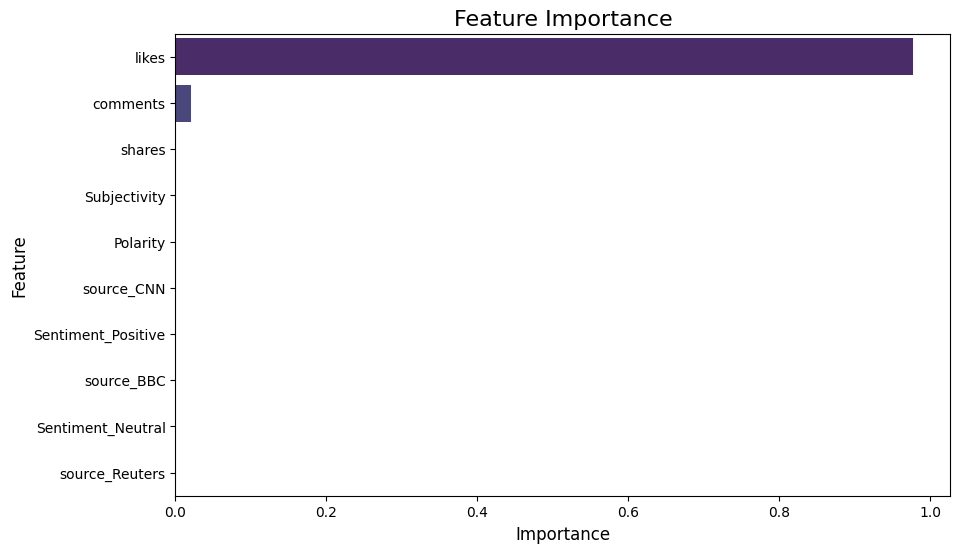

In [100]:
#feature importance
importances = decision_tree_model.feature_importances_
feature_names = x_test.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Conclusion

- In this project, we explored **sentiment analysis** and **engagement prediction** using a dataset featuring global news articles from renowned outlets such as **Al Jazeera**, **Reuters**, **BBC**, and **CNN**. Starting with advanced **NLP techniques**, we performed sentiment analysis on the text of news articles, generating meaningful visualizations to uncover sentiment patterns. 

- We then proceeded to calculate **total engagement** based on **likes**, **comments**, and **shares** and developed multiple machine learning models to predict this metric. Five models were evaluated, and their performances were compared using key metrics: **R² Score** and **RMSE**.